# Variational AutoEncoder

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder

In [3]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Build the decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 90,177
Trainable params: 90,177
Non-trainable params: 0
_______________________________________________________

## Define the VAE as a Model with a custom train_step

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train the VAE

### load data set

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

(70000, 28, 28, 1)

### start training

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=25, batch_size=128)

Epoch 1/25
547/547 [==============================] - 4s 6ms/step - loss: 147.9766 - reconstruction_loss: 138.9057 - kl_loss: 8.4241
Epoch 2/25
547/547 [==============================] - 4s 6ms/step - loss: 146.1505 - reconstruction_loss: 137.1772 - kl_loss: 8.4514
Epoch 3/25
547/547 [==============================] - 4s 6ms/step - loss: 144.5552 - reconstruction_loss: 135.9045 - kl_loss: 8.4684
Epoch 4/25
547/547 [==============================] - 3s 6ms/step - loss: 143.4730 - reconstruction_loss: 134.9157 - kl_loss: 8.4739
Epoch 5/25
547/547 [==============================] - 4s 6ms/step - loss: 142.7207 - reconstruction_loss: 134.1646 - kl_loss: 8.4805
Epoch 6/25
547/547 [==============================] - 4s 6ms/step - loss: 142.0318 - reconstruction_loss: 133.4476 - kl_loss: 8.4860
Epoch 7/25
547/547 [==============================] - 4s 6ms/step - loss: 141.3905 - reconstruction_loss: 132.9767 - kl_loss: 8.4808
Epoch 8/25
547/547 [==============================] - 4s 6ms/step - l

## Display a grid of sampled digits

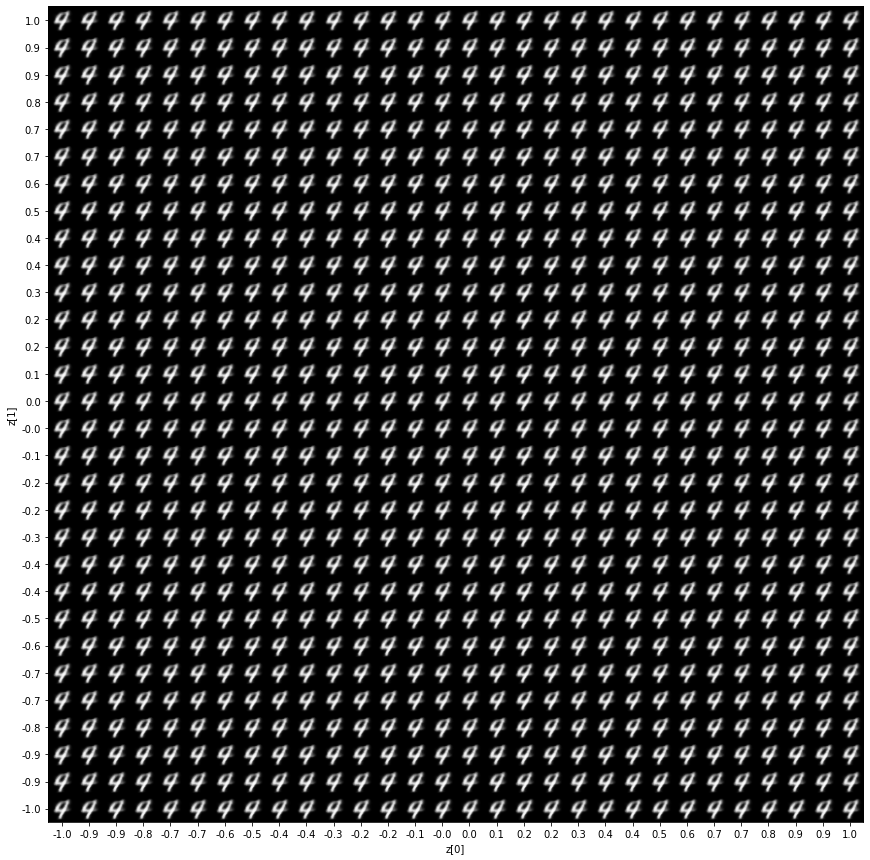

In [14]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi,0,0,0,1,0,0,0,0]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

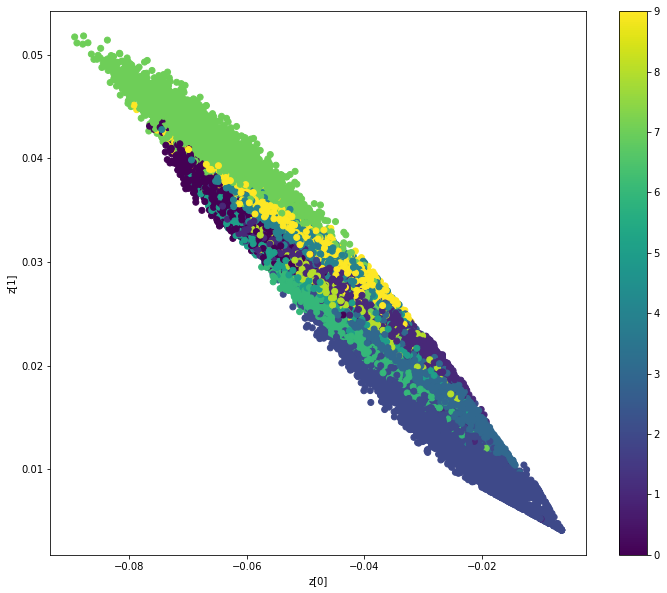

In [11]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [3]:
from tensorflow.keras import layers,optimizers,callbacks,Input,Model
img_height = 128
img_width = 128
img_channels = 2
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
# encoder model
latent_dim = 2

encoder_inputs = Input(shape=(img_height, img_width, img_channels))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 65536)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
# decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(int((img_height/4) * (img_width/4) * 64), activation="relu")(latent_inputs)
x = layers.Reshape((int(img_height/4), int(img_width/4), 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(img_channels, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             196608    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 2)       578       
Total params: 252,578
Trainable params: 252,578
Non-trainable params: 0
_____________________________________________________

In [4]:
# 载入测试集
import scipy.io as scio
mat = scio.loadmat('train/Htest.mat')
x_test = mat['H_test']
x_test = x_test.astype('float32')
padding_zeros=np.zeros((x_test.shape[0],1,128,2),dtype = np.float32)#补0至128*128
x_test = np.concatenate((padding_zeros,x_test,padding_zeros),axis=1)
print("x_test",x_test.shape)

x_test (2000, 128, 128, 2)


In [5]:
# 评价指标
def NMSE_t(x, x_hat):
    x_real = tf.reshape(x[:, :, :, 0], (len(x), -1))
    x_imag = tf.reshape(x[:, :, :, 1], (len(x), -1))
    x_hat_real = tf.reshape(x_hat[:, :, :, 0], (len(x_hat), -1))
    x_hat_imag = tf.reshape(x_hat[:, :, :, 1], (len(x_hat), -1))
    x_C = tf.complex(x_real - 0.5, x_imag - 0.5)
    x_hat_C = tf.complex(x_hat_real - 0.5, x_hat_imag - 0.5)
    power = tf.reduce_sum(tf.abs(x_C) ** 2, axis=1)
    mse = tf.reduce_sum(tf.abs(x_C - x_hat_C) ** 2, axis=1)
    nmse = tf.reduce_mean(mse / power)
    return nmse
def NMSE(x, x_hat):
    x_real = np.reshape(x[:, :, :, 0], (len(x), -1))
    x_imag = np.reshape(x[:, :, :, 1], (len(x), -1))
    x_hat_real = np.reshape(x_hat[:, :, :, 0], (len(x_hat), -1))
    x_hat_imag = np.reshape(x_hat[:, :, :, 1], (len(x_hat), -1))
    x_C = x_real - 0.5 + 1j * (x_imag - 0.5)
    x_hat_C = x_hat_real - 0.5 + 1j * (x_hat_imag - 0.5)
    power = np.sum(abs(x_C) ** 2, axis=1)
    mse = np.sum(abs(x_C - x_hat_C) ** 2, axis=1)
    nmse = np.mean(mse / power)
    return nmse
    
def Score(NMSE):
    score = (1 - NMSE) * 100
    return score

def score_train(y_true, y_pred):
    return Score(NMSE_t(y_true, y_pred))

In [8]:
encoder.load_weights("vae_encoder_-0.029.h5")
decoder.load_weights("vae_decoder_-0.029.h5")
_,_,y_test_e = encoder.predict(x_test)
y_test = decoder.predict(y_test_e)
NMSE_test=NMSE(x_test[:,1:127,:,:], y_test[:,1:127,:,:])
score_str=str(format(Score(NMSE_test), '.3f'))
print('The mean NMSE for test set is ' + str(NMSE_test),"score:",score_str)

The mean NMSE for test set is 1.0002912 score: -0.029


In [9]:
# 以下是可视化作图部分
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import math
def showImg(dataSet,n=20,COL=10):
    ROW=math.ceil(n/COL)
    PICSIZE=2

    plt.figure(figsize=(PICSIZE*COL, PICSIZE*ROW))
    for i in range(n):
        # display origoutal
        ax = plt.subplot(ROW, COL, i + 1)
        dataSetplo = abs(dataSet[i, :, :, 0]-0.5 + 1j*(dataSet[i, :, :, 1]-0.5))
        plt.imshow(np.max(np.max(dataSetplo))-dataSetplo.T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.invert_yaxis()
        # display reconstruction
        # ax = plt.subplot(2, n, i + 1 + n)
        # decoded_imgsplo = abs(y_test[i, :, :, 0]-0.5 + 1j*(y_test[i, :, :, 1]-0.5))
        # plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
        # plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        # ax.invert_yaxis()
    plt.show()

# 以下是可视化作图部分
def showImg_t(dataSet,n=20,COL=10):
    ROW=math.ceil(n/COL)
    PICSIZE=2

    plt.figure(figsize=(PICSIZE*COL, PICSIZE*ROW))
    for i in range(n):
        # display origoutal
        ax = plt.subplot(ROW, COL, i + 1)
        dataSetplo = tf.abs(tf.complex(dataSet[i, :, :, 0]-0.5, dataSet[i, :, :, 1]-0.5))
        plt.imshow(tf.reduce_max(tf.reduce_max(dataSetplo))-tf.transpose(dataSetplo))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.invert_yaxis()
        # display reconstruction
        # ax = plt.subplot(2, n, i + 1 + n)
        # decoded_imgsplo = abs(y_test[i, :, :, 0]-0.5 + 1j*(y_test[i, :, :, 1]-0.5))
        # plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
        # plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        # ax.invert_yaxis()
    plt.show()

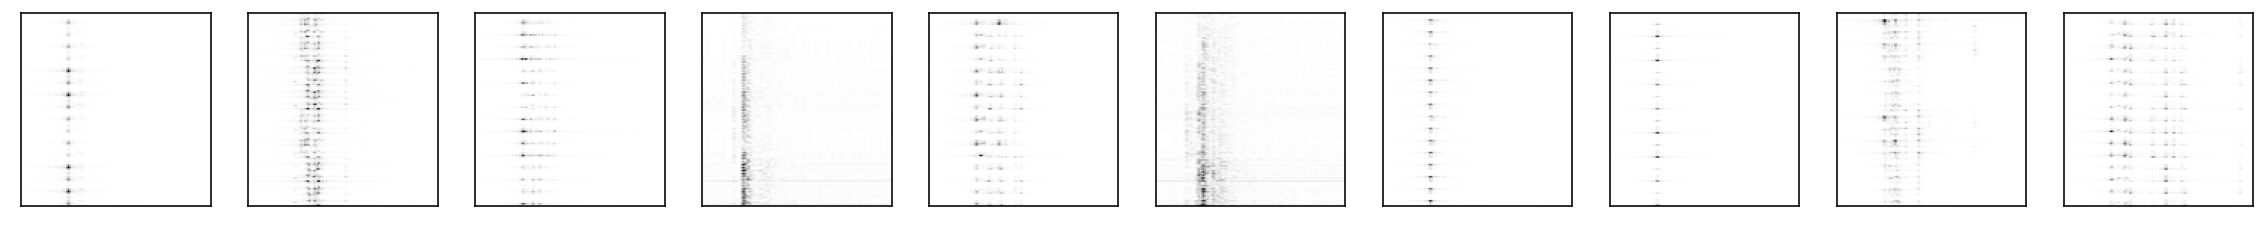

In [10]:
showImg(x_test[:,1:127,:,:],n=10,COL=10)

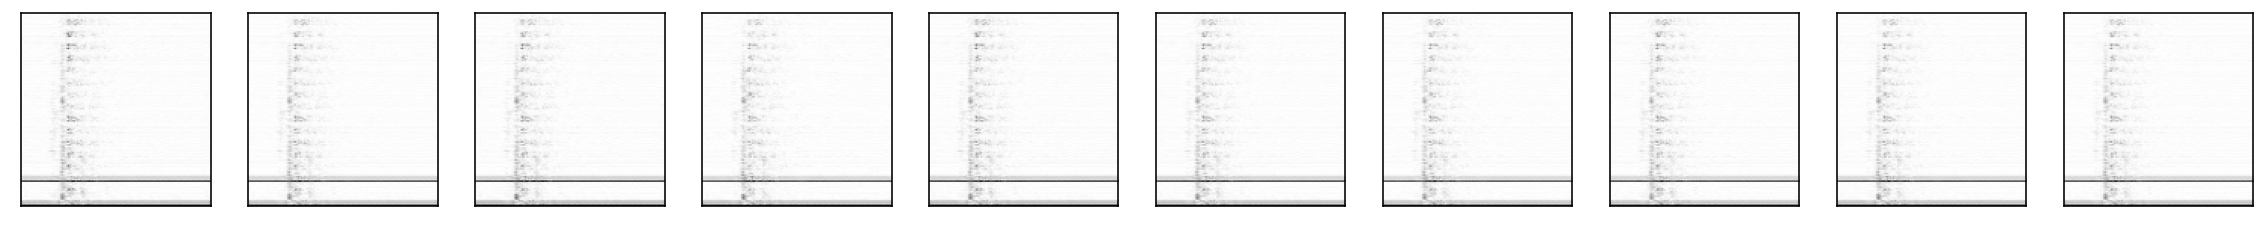

In [11]:
showImg(y_test[:,1:127,:,:],n=10,COL=10)

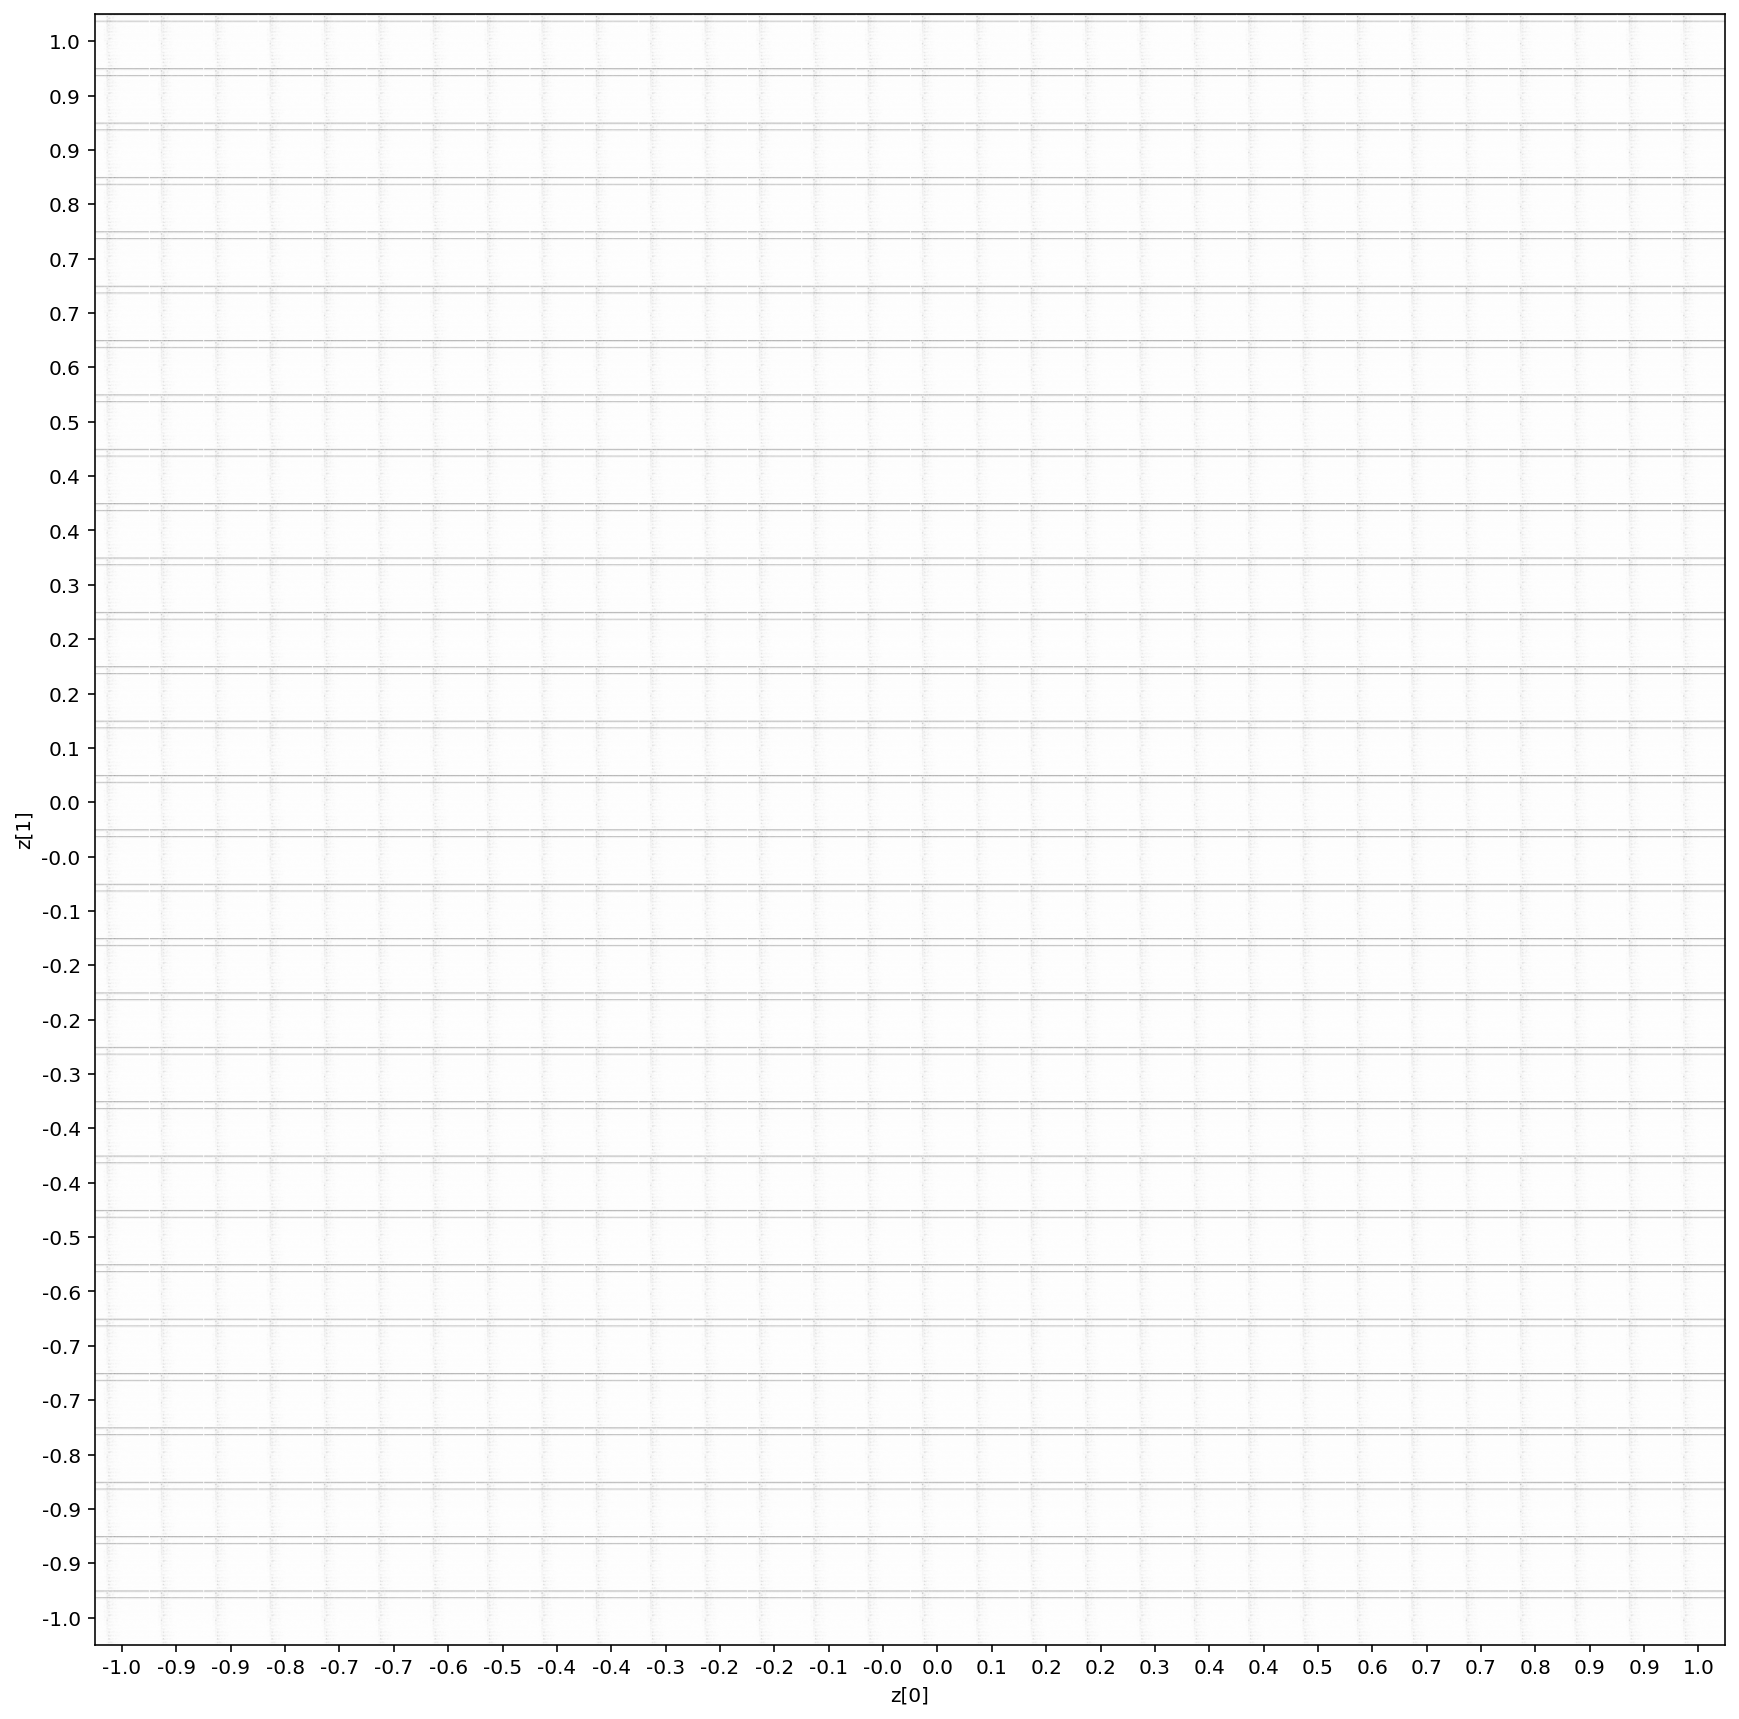

In [12]:
import matplotlib.pyplot as plt


n=30
figsize=15
# display a n*n 2D manifold of digits
digit_size = 128
scale = 1.0
figure = np.zeros((digit_size * n, digit_size * n,2))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size,2)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(figsize, figsize))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
dataSetplo = abs(figure[:,:,0]-0.5 + 1j*(figure[:,:,1]-0.5))
plt.imshow(np.max(np.max(dataSetplo))-dataSetplo.T, cmap="Greys_r")
plt.show()

In [23]:
y_test[4,10:20,30,:]

array([[0.50008166, 0.5000162 ],
       [0.49998677, 0.49999774],
       [0.50020456, 0.5000324 ],
       [0.49993932, 0.4998203 ],
       [0.5002473 , 0.4999348 ],
       [0.5001504 , 0.50004834],
       [0.5002194 , 0.50010735],
       [0.5001558 , 0.49988702],
       [0.500098  , 0.49997205],
       [0.5001249 , 0.49994302]], dtype=float32)

In [30]:
x_test[5,30:40,10,:]

array([[0.43206862, 0.5594513 ],
       [0.33378255, 0.67845166],
       [0.20196748, 0.720126  ],
       [0.2604278 , 0.6090252 ],
       [0.4068981 , 0.51248795],
       [0.48571154, 0.49086335],
       [0.50614595, 0.48886687],
       [0.5266719 , 0.47724554],
       [0.5591723 , 0.4595926 ],
       [0.5573844 , 0.45115918]], dtype=float32)